In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = np.asarray(df[name], dtype = np.float).mean()

    if sd is None:
        sd = np.asarray(df[name], dtype = np.float).std()

    df[name] = (np.asarray(df[name], dtype = np.float) - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [4]:

# This file is a CSV, just no CSV extension or headers

df_ = pd.read_csv("./train_70%.csv")
df_test = pd.read_csv("./test_30%.csv")
print("Read df_ {} rows.".format(len(df_)))
print("Read df_test {} rows.".format(len(df_test)))
#print("Read {} rows.".format(len(df1)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df_ = df_.drop(df_.columns[0], axis=1)
df_test = df_test.drop(df_test.columns[0], axis=1)

df_.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
df_test.dropna(inplace=True,axis=1)

Read df_ 3378 rows.
Read df_test 1448 rows.


In [5]:
df_.head(20)

,avg(pkt_len),stddev(pkt_len),fb_ratio,inter_arrival_time,pkt_count,duration,pkt_len,is_tcp,outcome
0,850.765612,345.487167,-1.000000,0.002862,1233,3.526154,1048994.0,0,voip
1,170.785714,384.539321,1.000000,0.019311,14,0.251042,2391.0,1,voip
2,170.785714,384.539321,1.000000,0.021926,14,0.285042,2391.0,1,voip
3,192.323529,350.338167,1.125000,0.194919,34,6.432321,6539.0,1,streaming
4,837.180556,667.089557,0.668449,0.001184,936,1.107098,783601.0,1,game
5,1320.000000,0.000000,-1.000000,0.000085,795,0.067596,1049400.0,1,download
6,51.000000,-1.000000,0.000000,-1.000000,1,0.003002,51.0,0,game
7,107.291667,199.128641,1.181818,0.244188,24,5.616323,2575.0,1,streaming
8,68.000000,-1.000000,0.000000,-1.000000,1,0.016523,68.0,0,game
9,170.785714,384.539321,1.000000,0.019459,14,0.252972,2391.0,1,voip


In [6]:
encode_numeric_zscore(df_, 'fb_ratio')
encode_numeric_zscore(df_, 'pkt_count')
encode_numeric_zscore(df_, 'inter_arrival_time')
encode_numeric_zscore(df_, 'stddev(pkt_len)')
encode_numeric_zscore(df_, 'avg(pkt_len)')
encode_numeric_zscore(df_, 'pkt_len')
encode_numeric_zscore(df_, 'duration')
encode_text_index(df_, 'outcome')

encode_numeric_zscore(df_test, 'fb_ratio')
encode_numeric_zscore(df_test, 'pkt_count')
encode_numeric_zscore(df_test, 'inter_arrival_time')
encode_numeric_zscore(df_test, 'stddev(pkt_len)')
encode_numeric_zscore(df_test, 'avg(pkt_len)')
encode_numeric_zscore(df_test, 'pkt_len')
encode_numeric_zscore(df_test, 'duration')
encode_text_index(df_test, 'outcome')

array(['download', 'game', 'streaming', 'voip'], dtype=object)

In [7]:
x_train, y_train = to_xy(df_, 'outcome')
x_test, y_test = to_xy(df_test, 'outcome')
# x, y = to_xy(df_, ' Label')

In [8]:
df_.head(20)

,avg(pkt_len),stddev(pkt_len),fb_ratio,inter_arrival_time,pkt_count,duration,pkt_len,is_tcp,outcome
0,1.207890,0.316372,-1.610124,-0.096689,0.929420,-0.162339,1.944402,0,3
1,-0.492414,0.502793,0.681685,-0.095893,-0.294377,-0.185909,-0.524746,1,3
2,-0.492414,0.502793,0.681685,-0.095766,-0.294377,-0.185664,-0.524746,1,3
3,-0.438559,0.339529,0.824923,-0.087389,-0.274298,-0.141425,-0.514960,1,2
4,1.173920,1.851588,0.301759,-0.096771,0.631251,-0.179748,1.318287,1,1
5,2.381220,-1.332861,-1.610124,-0.096824,0.489696,-0.187229,1.945360,1,0
6,-0.791941,-1.337635,-0.464220,-0.145254,-0.307428,-0.187694,-0.530267,0,1
7,-0.651183,-0.382291,0.890031,-0.085003,-0.284337,-0.147297,-0.524312,1,2
8,-0.749432,-1.337635,-0.464220,-0.145254,-0.307428,-0.187596,-0.530227,0,1
9,-0.492414,0.502793,0.681685,-0.095886,-0.294377,-0.185895,-0.524746,1,3


In [9]:
import keras.backend as K
K.clear_session()

In [10]:
# Create neural net
model = Sequential()

model.add(Dense(16, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))

In [11]:
# Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________


In [12]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.losses = []
        self.accs = []
        self.val_acc = []
        self.val_loss = []
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        acc = logs.get('acc')
        self.losses.append(loss)
        self.accs.append(acc)
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        val_acc = logs.get('val_acc')
        val_loss = logs.get('val_loss')
        self.val_acc.append(val_acc)
        self.val_loss.append(val_loss)

# Create an instance of the history callback
history_cb = LossHistory()

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
batch_size = 10
epochs = 300
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[history_cb],verbose=1, epochs=epochs)

Train on 3378 samples, validate on 1448 samples
Epoch 1/300
3378/3378 [==============================] - 0s - loss: 1.2527 - acc: 0.6341 - val_loss: 1.1134 - val_acc: 0.6644
Epoch 2/300
3378/3378 [==============================] - 0s - loss: 0.9925 - acc: 0.6835 - val_loss: 0.9205 - val_acc: 0.6809
Epoch 3/300
3378/3378 [==============================] - 0s - loss: 0.8475 - acc: 0.7108 - val_loss: 0.8484 - val_acc: 0.7155
Epoch 4/300
3378/3378 [==============================] - 0s - loss: 0.7906 - acc: 0.7339 - val_loss: 0.8155 - val_acc: 0.7175
Epoch 5/300
3378/3378 [==============================] - 0s - loss: 0.7576 - acc: 0.7374 - val_loss: 0.7925 - val_acc: 0.7134
Epoch 6/300
3378/3378 [==============================] - 0s - loss: 0.7353 - acc: 0.7430 - val_loss: 0.7760 - val_acc: 0.7169
Epoch 7/300
3378/3378 [==============================] - 0s - loss: 0.7192 - acc: 0.7487 - val_loss: 0.7662 - val_acc: 0.7203
Epoch 8/300
3378/3378 [==============================] - 0s - loss: 0.

3378/3378 [==============================] - 0s - loss: 0.5440 - acc: 0.7940 - val_loss: 0.6422 - val_acc: 0.7790
Epoch 66/300
3378/3378 [==============================] - 0s - loss: 0.5425 - acc: 0.7957 - val_loss: 0.6423 - val_acc: 0.7749
Epoch 67/300
3378/3378 [==============================] - 0s - loss: 0.5423 - acc: 0.7925 - val_loss: 0.6386 - val_acc: 0.7783
Epoch 68/300
3378/3378 [==============================] - 0s - loss: 0.5422 - acc: 0.7963 - val_loss: 0.6281 - val_acc: 0.7825
Epoch 69/300
3378/3378 [==============================] - 0s - loss: 0.5403 - acc: 0.7960 - val_loss: 0.6379 - val_acc: 0.7776
Epoch 70/300
3378/3378 [==============================] - 0s - loss: 0.5408 - acc: 0.7934 - val_loss: 0.6359 - val_acc: 0.7831
Epoch 71/300
3378/3378 [==============================] - 0s - loss: 0.5392 - acc: 0.7966 - val_loss: 0.6351 - val_acc: 0.7811
Epoch 72/300
3378/3378 [==============================] - 0s - loss: 0.5399 - acc: 0.7928 - val_loss: 0.6417 - val_acc: 0.77

3378/3378 [==============================] - 0s - loss: 0.5121 - acc: 0.8017 - val_loss: 0.6018 - val_acc: 0.7818
Epoch 130/300
3378/3378 [==============================] - 0s - loss: 0.5118 - acc: 0.7993 - val_loss: 0.6150 - val_acc: 0.7769
Epoch 131/300
3378/3378 [==============================] - 0s - loss: 0.5111 - acc: 0.7981 - val_loss: 0.6101 - val_acc: 0.7783
Epoch 132/300
3378/3378 [==============================] - 0s - loss: 0.5106 - acc: 0.8028 - val_loss: 0.6178 - val_acc: 0.7818
Epoch 133/300
3378/3378 [==============================] - 0s - loss: 0.5103 - acc: 0.8017 - val_loss: 0.6075 - val_acc: 0.7776
Epoch 134/300
3378/3378 [==============================] - 0s - loss: 0.5105 - acc: 0.8017 - val_loss: 0.6096 - val_acc: 0.7831
Epoch 135/300
3378/3378 [==============================] - 0s - loss: 0.5093 - acc: 0.7981 - val_loss: 0.6132 - val_acc: 0.7845
Epoch 136/300
3378/3378 [==============================] - 0s - loss: 0.5088 - acc: 0.8022 - val_loss: 0.6108 - val_ac

3378/3378 [==============================] - 0s - loss: 0.4958 - acc: 0.8055 - val_loss: 0.6152 - val_acc: 0.7790
Epoch 194/300
3378/3378 [==============================] - 0s - loss: 0.4947 - acc: 0.8034 - val_loss: 0.5954 - val_acc: 0.7756
Epoch 195/300
3378/3378 [==============================] - 0s - loss: 0.4946 - acc: 0.8079 - val_loss: 0.5945 - val_acc: 0.7742
Epoch 196/300
3378/3378 [==============================] - 0s - loss: 0.4948 - acc: 0.8064 - val_loss: 0.6162 - val_acc: 0.7811
Epoch 197/300
3378/3378 [==============================] - 0s - loss: 0.4942 - acc: 0.8028 - val_loss: 0.6084 - val_acc: 0.7797
Epoch 198/300
3378/3378 [==============================] - 0s - loss: 0.4937 - acc: 0.8076 - val_loss: 0.6129 - val_acc: 0.7797
Epoch 199/300
3378/3378 [==============================] - 0s - loss: 0.4942 - acc: 0.8070 - val_loss: 0.6062 - val_acc: 0.7769
Epoch 200/300
3378/3378 [==============================] - 0s - loss: 0.4932 - acc: 0.8061 - val_loss: 0.6159 - val_ac

3378/3378 [==============================] - 0s - loss: 0.4855 - acc: 0.8079 - val_loss: 0.5891 - val_acc: 0.7783
Epoch 258/300
3378/3378 [==============================] - 0s - loss: 0.4860 - acc: 0.8058 - val_loss: 0.5896 - val_acc: 0.7776
Epoch 259/300
3378/3378 [==============================] - 0s - loss: 0.4847 - acc: 0.8102 - val_loss: 0.5982 - val_acc: 0.7811
Epoch 260/300
3378/3378 [==============================] - 0s - loss: 0.4847 - acc: 0.8102 - val_loss: 0.6019 - val_acc: 0.7762
Epoch 261/300
3378/3378 [==============================] - 0s - loss: 0.4845 - acc: 0.8070 - val_loss: 0.6147 - val_acc: 0.7811
Epoch 262/300
3378/3378 [==============================] - 0s - loss: 0.4855 - acc: 0.8108 - val_loss: 0.6022 - val_acc: 0.7776
Epoch 263/300
3378/3378 [==============================] - 0s - loss: 0.4837 - acc: 0.8097 - val_loss: 0.5971 - val_acc: 0.7825
Epoch 264/300
3378/3378 [==============================] - 0s - loss: 0.4847 - acc: 0.8091 - val_loss: 0.6047 - val_ac

In [14]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

Validation score: 0.7803867403314917


In [15]:
from sklearn.metrics import classification_report,confusion_matrix
Cm = confusion_matrix(y_eval,pred)
C = np.sum(Cm)
Cm = Cm/C
print('Confusion Matrix:')
print(np.array_str(Cm, precision=4, suppress_small=True))

Confusion Matrix:
[[ 0.0946  0.0117  0.0014  0.0552]
 [ 0.0007  0.0394  0.0076  0.0594]
 [ 0.0062  0.02    0.0518  0.0318]
 [ 0.      0.0173  0.0083  0.5946]]


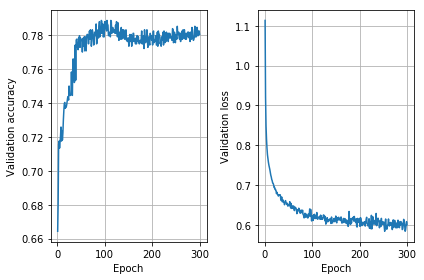

In [16]:
valAcc = history_cb.val_acc
valLoss = history_cb.val_loss
epoch_it = np.arange(1,301)
plt.subplot(121)
plt.plot(epoch_it, valAcc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.subplot(122)
plt.plot(epoch_it, valLoss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.tight_layout()
plt.show()

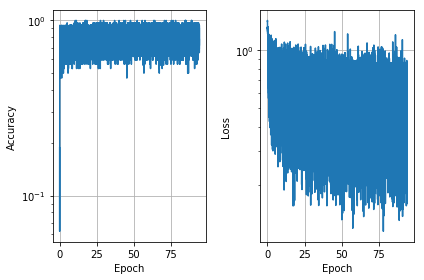

In [18]:
Ls = history_cb.losses
Acc = history_cb.accs
ntr = np.shape(x_train)[0]
epochNum = []
for i in range(31800):
    epochNum.append(i*10/ntr)

plt.subplot(121)
matplotlib.pyplot.semilogy(epochNum, Acc)
# plt.plot(epochNum, Acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

plt.subplot(122)
matplotlib.pyplot.semilogy(epochNum, Ls)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
# plt.show()

# plt.axis([0.3,3,0.96,1])
plt.show()

In [19]:
# print(Cm[0])
nd = [None]*4
for i,nd in enumerate (Cm):
    for j in range (len(nd)):
        
        print(i,j,"%0.2f"%(nd[j]/np.sum(nd)))
    print("---")

0 0 0.58
0 1 0.07
0 2 0.01
0 3 0.34
---
1 0 0.01
1 1 0.37
1 2 0.07
1 3 0.55
---
2 0 0.06
2 1 0.18
2 2 0.47
2 3 0.29
---
3 0 0.00
3 1 0.03
3 2 0.01
3 3 0.96
---
